In [1]:
# Install required packages
!pip install torch torchvision pillow matplotlib tqdm kaggle

In [2]:
#Import libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
torch.manual_seed(0)  # For reproducibility

In [3]:
# Set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Upload Kaggle API key
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umair851","key":"8a4f08c2444ada5929398896e9a963f2"}'}

In [5]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:

# Download Anime Face dataset from Kaggle
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip -d animefacedataset
dataset_dir = '/content/animefacedataset/images'

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace animefacedataset/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
# Visualization function
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

In [9]:
# Custom Dataset for Anime Faces
class AnimeFaceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [10]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=128, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, kernel_size=4, stride=1, padding=0),  # 4x4
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),  # 64x64
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [11]:
def get_noise(n_samples, z_dim, device=device):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
# Discriminator
class Discriminator (nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),  # 4x4
            self.make_disc_block(hidden_dim * 8, 1, kernel_size=4, stride=1, padding=0, final_layer=True),  # 1x1
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [13]:
# Gradient Penalty Functions
def get_gradient(disc, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = disc(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [14]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Loss Functions
def get_gen_loss(disc_fake_pred):
    return -disc_fake_pred.mean()

def get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda):
    return disc_fake_pred.mean() - disc_real_pred.mean() + c_lambda * gp

In [30]:
# Training Initializations
n_epochs = 100
z_dim = 128
display_step = 200
batch_size = 318
lr_gen = 0.0001
lr_disc = 0.0001
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 50
disc_repeats = 1
resume_training = True  # Set to True to resume, False to start fresh

# Data transformation and loading
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = AnimeFaceDataset(img_dir=dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Paths for saving models
base_path = '/content/drive/MyDrive/wgan_gp_anime'
os.makedirs(base_path, exist_ok=True)
gen_path = os.path.join(base_path, 'generator_epoch_{}.pth')
disc_path = os.path.join(base_path, 'critic_epoch_{}.pth')
opt_path = os.path.join(base_path, 'optimizers_epoch_{}.pth')

# Initialize models and optimizers
gen = Generator(z_dim=z_dim, im_chan=3).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta_1, beta_2))
disc = Discriminator(im_chan=3).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr_disc, betas=(beta_1, beta_2))

In [16]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

Resuming from epoch 41
Epoch 41: lr_gen=0.0001, lr_disc=0.0001, disc_repeats=3


  0%|          | 0/200 [00:00<?, ?it/s]

Step 8200, Gradient Penalty: 0.0035570431500673294
Step 8200, Gradient Penalty: 0.002913337666541338
Step 8200, Gradient Penalty: 0.0035156456287950277
Epoch 41, Step 8200: Generator loss: 0.3589, Discriminator loss: -0.0044


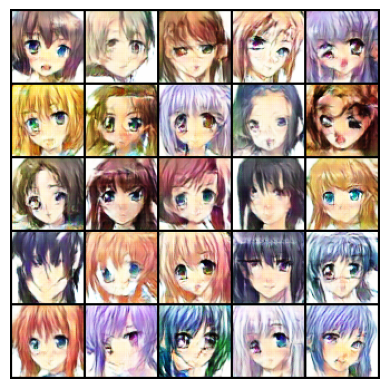

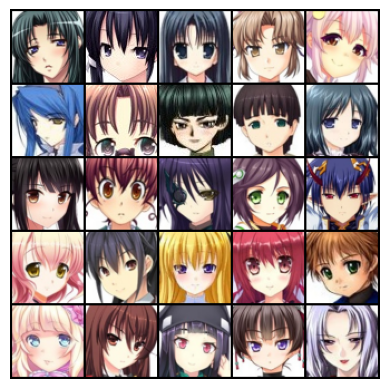

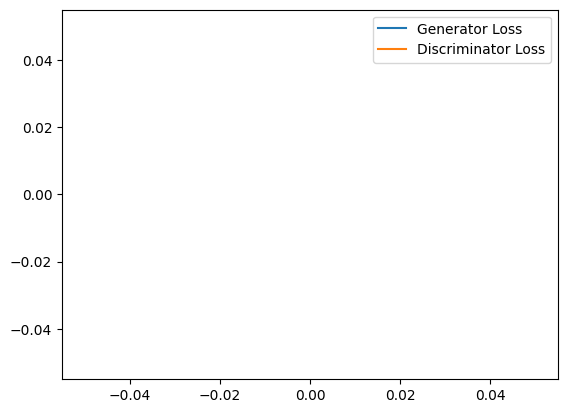

Saved models for epoch 41 to Google Drive
Epoch 42: lr_gen=0.0001, lr_disc=0.0001, disc_repeats=3


  0%|          | 0/200 [00:00<?, ?it/s]

Step 8400, Gradient Penalty: 0.0011906326981261373
Step 8400, Gradient Penalty: 0.0010725604370236397
Step 8400, Gradient Penalty: 0.0012112779077142477
Epoch 42, Step 8400: Generator loss: 71.7461, Discriminator loss: -0.7336


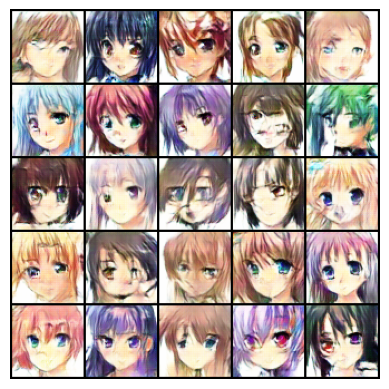

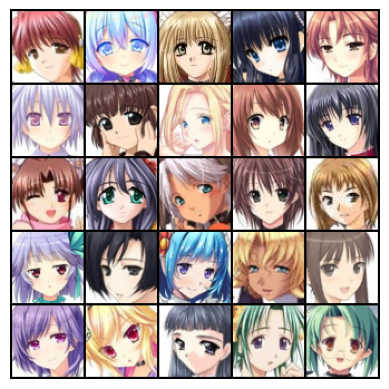

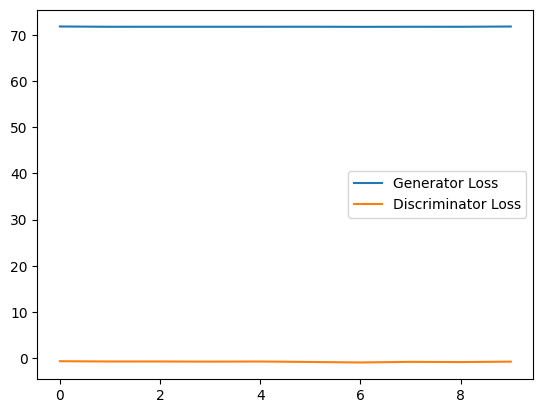

Saved models for epoch 42 to Google Drive
Epoch 43: lr_gen=0.0001, lr_disc=0.0001, disc_repeats=3


  0%|          | 0/200 [00:00<?, ?it/s]

Step 8600, Gradient Penalty: 0.0011508263414725661
Step 8600, Gradient Penalty: 0.0010291406651958823
Step 8600, Gradient Penalty: 0.0012820428237318993
Epoch 43, Step 8600: Generator loss: 72.0204, Discriminator loss: -0.9773


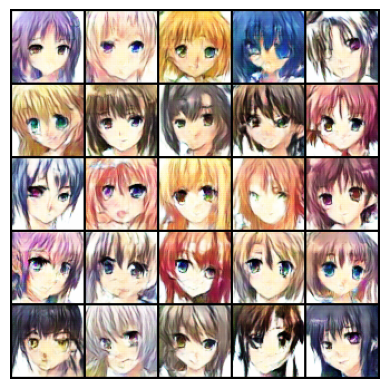

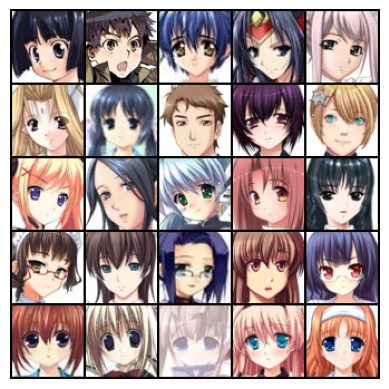

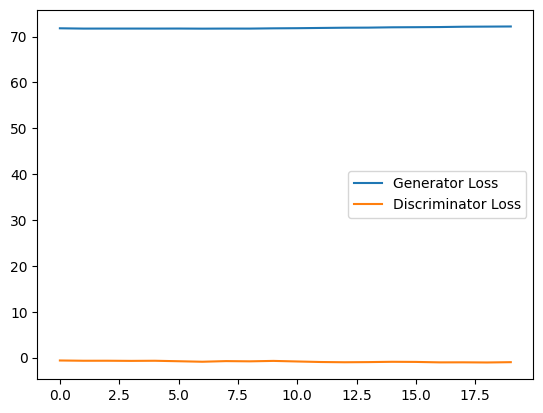

In [ ]:
# Resume training logic (unchanged)
start_epoch = 40
resume_training = True

if resume_training:
    for epoch in range(start_epoch, -1, -1):
        gen_file = gen_path.format(epoch)
        disc_file = disc_path.format(epoch)
        opt_file = opt_path.format(epoch)
        if os.path.exists(gen_file) and os.path.exists(disc_file) and os.path.exists(opt_file):
            print(f"Resuming from epoch {epoch + 1}")
            gen.load_state_dict(torch.load(gen_file))
            disc.load_state_dict(torch.load(disc_file))
            checkpoint = torch.load(opt_file)
            gen_opt.load_state_dict(checkpoint['gen_opt'])
            disc_opt.load_state_dict(checkpoint['disc_opt'])
            start_epoch = epoch + 1
            break
    if start_epoch == 0:
        print("No saved models found; starting from scratch despite resume_training=True")
        gen = gen.apply(weights_init)
        disc = disc.apply(weights_init)
else:
    print("Starting training from scratch")
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

# Training Loop
cur_step = start_epoch * len(dataloader)
generator_losses = []
discriminator_losses = []

for epoch in range(start_epoch, n_epochs):
    # Hyperparameter adjustments
    if epoch >= 40:
        for param_group in gen_opt.param_groups:
            param_group['lr'] = 1e-04
        for param_group in disc_opt.param_groups:
            param_group['lr'] = 1e-04
        disc_repeats = 3
        print(f"Epoch {epoch}: lr_gen={1e-04}, lr_disc={1e-04}, disc_repeats={disc_repeats}")

    if epoch >= 45:
        c_lambda = 20
        beta_1 = 0.0
        for param_group in gen_opt.param_groups:
            param_group['betas'] = (beta_1, beta_2)
        for param_group in disc_opt.param_groups:
            param_group['betas'] = (beta_1, beta_2)
        print(f"Epoch {epoch}: c_lambda={c_lambda}, beta_1={beta_1}")

    # New adjustments
    if epoch >= 69:
        c_lambda = 30  # Increase to strengthen discriminator
        print(f"Epoch {epoch}: Increased c_lambda to {c_lambda}")

    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Add noise to discriminator inputs
        noise_factor = 0.05
        real_noisy = real + noise_factor * torch.randn_like(real, device=device)
        real_noisy = torch.clamp(real_noisy, -1, 1)

        mean_iteration_discriminator_loss = 0
        for _ in range(disc_repeats):
            disc_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            fake_noisy = fake.detach() + noise_factor * torch.randn_like(fake, device=device)
            fake_noisy = torch.clamp(fake_noisy, -1, 1)

            disc_fake_pred = disc(fake_noisy)
            disc_real_pred = disc(real_noisy)

            # Label smoothing
            smoothing_factor = 0.1
            disc_fake_pred = disc_fake_pred + smoothing_factor * torch.randn_like(disc_fake_pred, device=device)
            disc_real_pred = disc_real_pred + smoothing_factor * torch.randn_like(disc_real_pred, device=device)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(disc, real_noisy, fake_noisy, epsilon)
            gp = gradient_penalty(gradient)
            if cur_step % display_step == 0:
                print(f"Step {cur_step}, Gradient Penalty: {gp.item()}")
            disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda)
            mean_iteration_discriminator_loss += disc_loss.item() / disc_repeats
            disc_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1.0)
            disc_opt.step()
        discriminator_losses.append(mean_iteration_discriminator_loss)

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
        gen_opt.step()
        generator_losses.append(gen_loss.item())

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, Step {cur_step}: Generator loss: {gen_mean:.4f}, Discriminator loss: {disc_mean:.4f}")
            # Adjust disc_repeats if discriminator loss grows too large
            if disc_mean > 5:
                disc_repeats = 2
                print(f"Step {cur_step}: Increased disc_repeats to {disc_repeats} due to high discriminator loss")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1).cpu(),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1).cpu(),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

    # Save models at the end of each epoch
    torch.save(gen.state_dict(), gen_path.format(epoch))
    torch.save(disc.state_dict(), disc_path.format(epoch))
    torch.save({
        'gen_opt': gen_opt.state_dict(),
        'disc_opt': disc_opt.state_dict()
    }, opt_path.format(epoch))
    print(f"Saved models for epoch {epoch} to Google Drive")

# Final save
torch.save(gen.state_dict(), os.path.join(base_path, 'generator_final.pth'))
torch.save(disc.state_dict(), os.path.join(base_path, 'critic_final.pth'))
torch.save({
    'gen_opt': gen_opt.state_dict(),
    'disc_opt': disc_opt.state_dict()
}, os.path.join(base_path, 'optimizers_final.pth'))
print("Training completed and final models saved")